In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
data = load_dataset("valhalla/emoji-dataset")["train"]

In [ ]:
count = 0
for row in data:
  if "man" in row["text"]: #all emojis with the term man or woman
    count += 1
count

610

In [ ]:
man = 0
woman = 0
multiple = 0

filtered = []

for row in data:

    text = row['text'].split(' ')
    singular = {'man':0, 'woman':0, 'boy':0, 'girl':0}
    plural = {'men':0, 'women':0, 'family':0}

    for word in text:
        if word in singular.keys():
            singular[word] += 1

        if word in plural.keys():
            plural[word] +=1

    if sum(singular.values()) > 1 or sum(plural.values()) >=1:
        multiple += 1
        filtered.append({**row, 'class':1})

    elif singular['man'] == 1:
        man +=1
        filtered.append({**row, 'class':2})

    elif singular['woman'] == 1:
        filtered.append({**row, 'class':3})
        woman += 1


print(man, woman, multiple)

In [ ]:
def contains_man(row):
  return "man" in row["text"]

filtered = data.filter(contains_man)

Filter:   0%|          | 0/2749 [00:00<?, ? examples/s]

In [ ]:
df = filtered.to_pandas()

In [ ]:
!pip install pillow

In [2]:
import pandas as pd
import PIL

In [1]:
from PIL import Image, ImageOps
import numpy as np
import io
import random
from IPython.display import display

def process_image(bytes_arr):
  image = Image.open(io.BytesIO(bytes_arr))
  size = (64,64)
  resized_image = image.resize(size, Image.ANTIALIAS)
  image_array = np.array(resized_image)
  return image_array

def augment_image(og_array):
  og = Image.fromarray(og_array)
  augmentations = ["h", "v", "r"] #horizontal flip, vertical_flip, rotate
  augmentation = random.choice(augmentations)
  aug = None
  if augmentation == "h":
    aug = ImageOps.mirror(og)
  elif augmentation == "v":
    aug = ImageOps.flip(og)
  else:
    d = random.choice([90,180,270])
    aug = og.rotate(d)
  aug_array = np.array(aug)
  return aug_array

def show_image(image_array):
  image = Image.fromarray(image_array)
  display(image)


In [3]:
augmented_dataset = []
for image in df["image"]:
  bytes_arr = image["bytes"]
  image_arr = process_image(bytes_arr)
  augmented_dataset.append(image_arr)
  augmented_dataset.append(augment_image(image_arr))
final_dataset = np.array(augmented_dataset)

NameError: name 'df' is not defined

In [ ]:
np.save("processed_data.npy", final_dataset)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Output: (16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (16, 32, 32)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (32, 16, 16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Output: (16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # Output: (3, 64, 64)
            nn.Sigmoid()  # Use sigmoid to scale the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
import numpy as np

processed_data = np.load("processed_data.npy")
np.random.shuffle(processed_data)

X_train, X_valid, X_test = processed_data[:600], processed_data[600:800], processed_data[800:1000]

In [4]:
def normalize_create_tensor(data):
  """
  Normalize data and create a tensor
  """
  n = len(data)
  data_scaled = data.astype(np.float32)/255.0
  data_reshaped = np.transpose(data_scaled, (0,3,1,2))
  data_tensor = torch.tensor(data_reshaped)
  # print(f'Shape: {data_tensor.shape}')  # Expected shape: (N, 3, 64, 64)
  # print(f'Type: {data_tensor.dtype}')   # Should be torch.float32
  return data_tensor


In [5]:
X_train_tensor = normalize_create_tensor(X_train)
X_valid_tensor = normalize_create_tensor(X_valid)
X_test_tensor = normalize_create_tensor(X_test)

In [6]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training loss: {title}')
    plt.plot(valid_losses, label=f'Validation loss: {title}')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



epoch: 0, train loss: 0.14042402803897858, valid loss: 0.13907071948051453
epoch: 10, train loss: 0.09130176156759262, valid loss: 0.08619074523448944
epoch: 20, train loss: 0.06591933965682983, valid loss: 0.06185470521450043
epoch: 30, train loss: 0.04410899430513382, valid loss: 0.04215383529663086
epoch: 40, train loss: 0.0368146076798439, valid loss: 0.03589056059718132
epoch: 50, train loss: 0.032737307250499725, valid loss: 0.03206993266940117
epoch: 60, train loss: 0.02989153563976288, valid loss: 0.029309673234820366
epoch: 70, train loss: 0.02724042534828186, valid loss: 0.02672923356294632
epoch: 80, train loss: 0.025426054373383522, valid loss: 0.02515406906604767
epoch: 90, train loss: 0.023852840065956116, valid loss: 0.02351667732000351
epoch: 100, train loss: 0.02151935175061226, valid loss: 0.021111255511641502
epoch: 110, train loss: 0.017281103879213333, valid loss: 0.016786493360996246
epoch: 120, train loss: 0.015377838164567947, valid loss: 0.015021692961454391
ep

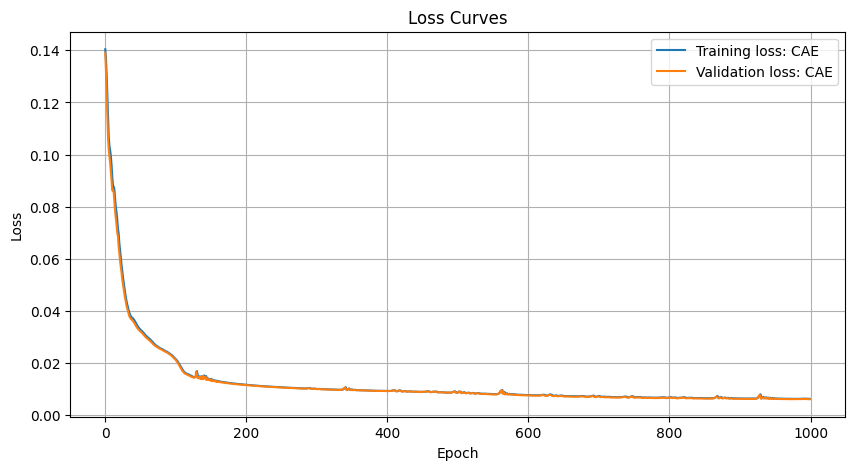

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn

cae = ConvAutoEncoder()
train_losses = []
valid_losses = []

def train_CAE():
  loss_fn = nn.MSELoss()
  lr = 0.0075
  optimizer = optim.Adam(cae.parameters(), lr)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.1)
  epochs = 1000
  for epoch in range(epochs):
    cae.train()
    output = cae.forward(X_train_tensor)
    loss = loss_fn(output, X_train_tensor)
    train_losses.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cae.eval()
    with torch.no_grad():
      valid_output = cae.forward(X_valid_tensor)
      valid_loss = loss_fn(valid_output, X_valid_tensor)
      valid_losses.append(valid_loss.item())
    if not epoch % 10:
      print(f"epoch: {epoch}, train loss: {loss}, valid loss: {valid_loss}")


train_CAE()
plot_loss_curves(train_losses, valid_losses, "CAE")


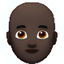

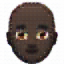

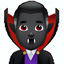

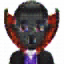

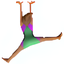

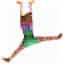

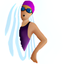

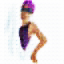

In [11]:
def predict_and_display_image(i):
  image_arr = X_test[i] #np array of image
  show_image(image_arr)
  X = np.array([image_arr])
  norm_X = normalize_create_tensor(X)
  output = cae.forward(norm_X)
  output = output.detach().cpu()
  output_array = (output.numpy()*255).astype(np.uint8) #convert to numpy
  output_array = np.transpose(output_array[0], (1, 2, 0))
  show_image(output_array)


predict_and_display_image(0)
predict_and_display_image(10)
predict_and_display_image(20)
predict_and_display_image(30)


In [13]:
from google.colab import files

def save_model(model, filename="model.pth"):
    torch.save(model, filename)
    print(f"Model saved to {filename}")

save_model(cae, "cae_basic.pth")
files.download("cae_basic.pth")

Model saved to cae_basic.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>